# 车辆识别

使用openvino预训练模型库中的车辆识别模型，导入模型、输入图像、图像预处理、执行推断、结果解析及可视化。

同济大学-张子豪 2020-07-31

# 打开openvino环境

In [1]:
!source /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


运行上面的代码无效的话，在命令行中单独运行感叹号之后的命令。

# 导入工具库

In [2]:
import openvino
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 初始化Inference Engine

In [3]:
import os
import sys
import logging as log
from openvino.inference_engine import IENetwork, IECore

class Network:
    '''
    Load and store information for working with the Inference Engine,
    and any loaded models.
    '''

    def __init__(self):
        self.plugin = None
        self.input_blob = None
        self.exec_network = None


    def load_model(self, model, device="CPU", cpu_extension=None):
        '''
        载入权重文件，构建模型，CPU为默认设备
        '''
        model_xml = model
        model_bin = os.path.splitext(model_xml)[0] + ".bin"

        # 初始化IECore
        self.plugin = IECore()

        # 如果需要的话，增加CPU扩展文件
        if cpu_extension and "CPU" in device:
            self.plugin.add_extension(cpu_extension, device)

        # 读取网络权重和网络结构
        # network = IENetwork(model=model_xml, weights=model_bin)
        network = self.plugin.read_network(model=model_xml, weights=model_bin)
        
        # Load the IENetwork into the plugin
        self.exec_network = self.plugin.load_network(network, device)

        # 获取输入层
        self.input_blob = next(iter(network.inputs))

        # 返回输入层尺寸维度，用于预处理
        return network.inputs[self.input_blob].shape


    def sync_inference(self, image):
        '''
        输入图像，执行同步推断
        '''
        self.exec_network.infer({self.input_blob: image})
        return


    def extract_output(self):
        '''
        从网络输出层中获取结果列表
        '''
        return self.exec_network.requests[0].outputs


In [4]:
# 实例化Network，用于调用Inference Engine
inference_network = Network()

In [5]:
# 载入模型，并返回模型输入维度
n, c, h, w = inference_network.load_model('models/vehicle-attributes-recognition-barrier-0039.xml', 'CPU', None)

In [6]:
n

1

In [7]:
c

3

In [8]:
h

72

In [9]:
w

72

# 导入图片

In [10]:
image_path = 'images/blue-car.jpg'

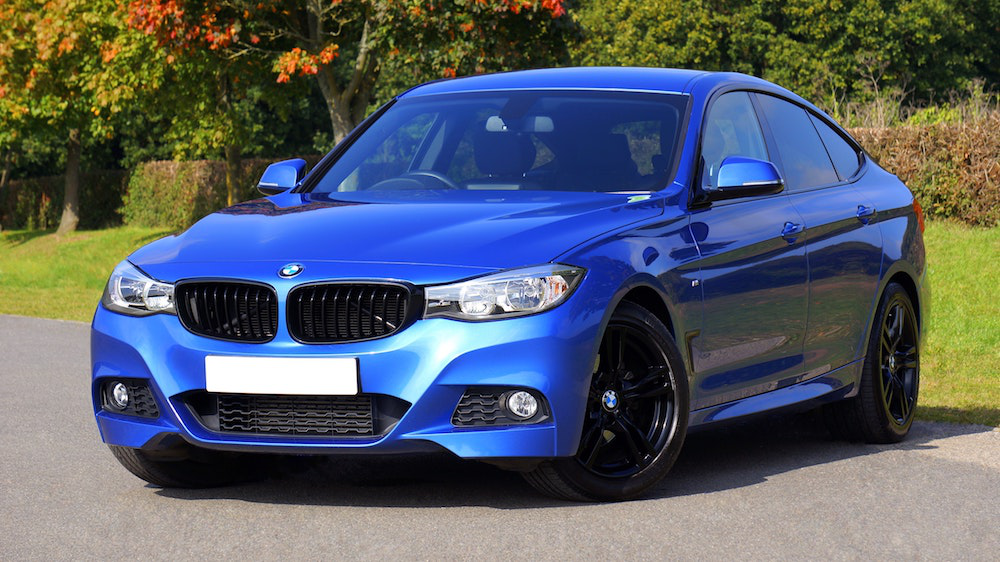

In [11]:
from PIL import Image
im = Image.open(image_path)
im

In [12]:
# 读入图像
image = cv2.imread(image_path)

In [13]:
image.shape

(562, 1000, 3)

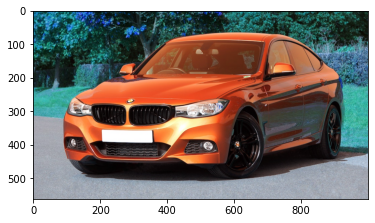

In [14]:
plt.imshow(image)
plt.show()

车辆为橙色的原因是，opencv读入图片是以BGR色彩通道读入的，与普通图像RGB色彩通道不同。

# 预处理

In [15]:
def preprocessing(input_image, height, width):
    '''
    Given an input image, height and width:
    - Resize to width and height
    - Transpose the final "channel" dimension to be first
    - Reshape the image to add a "batch" of 1 at the start 
    '''
    image = np.copy(input_image)
    image = cv2.resize(image, (width, height))
    image = image.transpose((2,0,1))
    image = image.reshape(1, 3, height, width)

    return image

In [16]:
preprocessed_image = preprocessing(image, h, w)

In [17]:
preprocessed_image.shape

(1, 3, 72, 72)

# 可视化预处理之后的图像

In [18]:
resized_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [19]:
resized_image = cv2.resize(resized_image, (w, h))

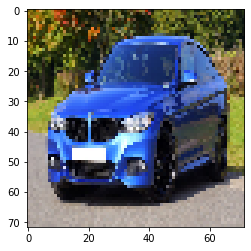

In [20]:
plt.imshow(resized_image)

# 在Inference Engine中进行推断

In [21]:
# 执行同步推断
inference_network.sync_inference(preprocessed_image)

In [22]:
# 获取推断结果
output = inference_network.extract_output()

In [23]:
output

{'color': array([[[[9.6967847e-07]],
 
         [[2.3289740e-06]],
 
         [[2.5214624e-07]],
 
         [[3.1800673e-07]],
 
         [[5.1445335e-07]],
 
         [[9.9999499e-01]],
 
         [[5.3769037e-07]]]], dtype=float32),
 'type': array([[[[9.9867368e-01]],
 
         [[4.0327859e-04]],
 
         [[8.6129265e-04]],
 
         [[6.1770072e-05]]]], dtype=float32)}

# 推断结果后处理

In [24]:
color = output['color'].flatten()
car_type = output['type'].flatten()
color_pred = np.argmax(color)
type_pred = np.argmax(car_type)

In [25]:
processed_output = color_pred, type_pred

In [26]:
processed_output

(5, 0)

颜色预测结果的索引为5，类型预测结果的索引为0

# 可视化结果并保存

In [27]:
# 获取颜色和类型预测结果
CAR_COLORS = ["white", "gray", "yellow", "red", "green", "blue", "black"]
CAR_TYPES = ["car", "bus", "truck", "van"]
color = CAR_COLORS[processed_output[0]]
car_type = CAR_TYPES[processed_output[1]]

In [28]:
color

'blue'

In [29]:
car_type

'car'

In [30]:
# 获取颜色和类型置信度
color_score = output['color'].flatten()[processed_output[0]]
type_score = output['type'].flatten()[processed_output[1]]

In [31]:
color_score

0.999995

In [32]:
type_score

0.9986737

In [33]:
# Scale the output text by the image shape
scaler = max(int(image.shape[0] / 1000), 1)

In [34]:
scaler

1

In [41]:
# 将识别结果显示在图片上，各参数依次是：图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
output_image = cv2.putText(image, 
    "Type: {:^8} Score:{:.3f}".format(car_type, type_score), 
    (25 * scaler, 50 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 
    1 * scaler, (255, 255, 255), 2 * scaler)

output_image = cv2.putText(image, 
    "Color:{:^8} Score:{:.3f}".format(color, color_score), 
    (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 
    1 * scaler, (255, 255, 255), 2 * scaler)

In [36]:
print("Type: {:<7} Score:{:.3f}%".format(car_type, type_score*100))
print("Color:{:<7} Score:{:.3f}%".format(color, color_score*100))

Type: car     Score:99.867%
Color:blue    Score:99.999%


In [37]:
output_image.shape

(562, 1000, 3)

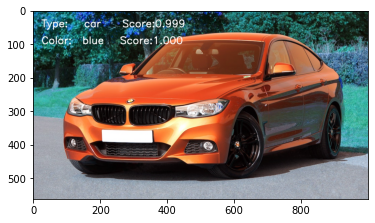

In [38]:
plt.imshow(output_image)
plt.show()

In [39]:
# 将处理后的图像保存至本地
output_path = "outputs/{}-output.png".format('zihao')
cv2.imwrite(output_path, output_image)

True

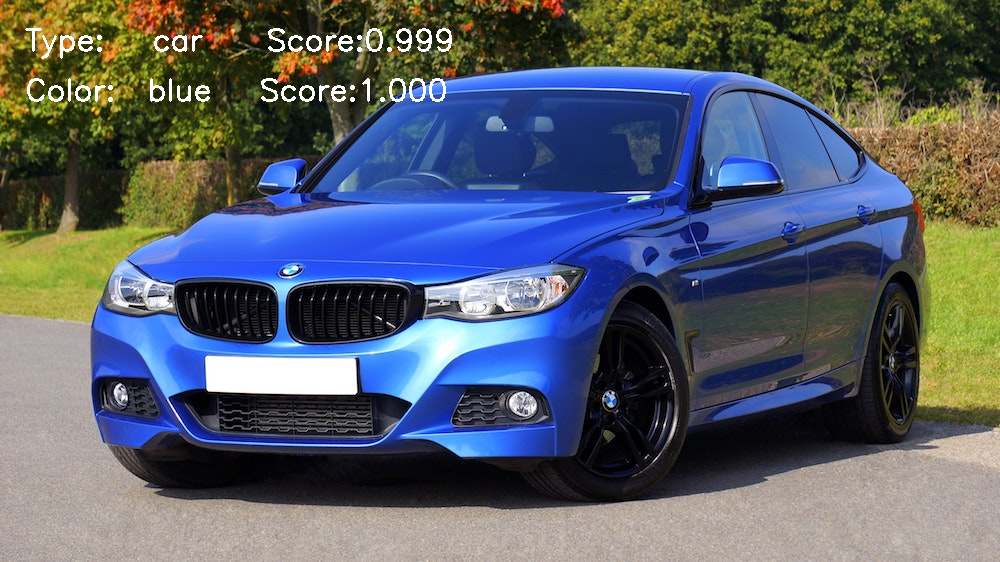

In [40]:
from PIL import Image
im = Image.open(output_path)
im